In [1]:

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import pandas as pd

import numpy as np
import scipy as sp

import pymc3 as pm
import theano.tensor as tt


import seaborn as sns
from google.colab import drive

from matplotlib import cm
from pymc3.gp.util import plot_gp_dist
drive.mount('/content/drive')







Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Primary resources for making this: 
https://docs.pymc.io/notebooks/GP-Marginal.html
https://github.com/fonnesbeck/gp_regression

Look into: 
https://docs.pymc.io/notebooks/posterior_predictive.html


In [2]:
##### OPTIONS #####

map = 0         # 1 - use find map, 0 - sample 
samples = 2000
tune = 2000

errorbars = 0   # plot error bars on surface plot 
smp_rt = 2      # every nth point of true data
num_gen = 150   # given n will produce n x n points of predictions




data = np.genfromtxt('/content/drive/My Drive/data/gyro_fake_data_v1.csv', delimiter=',', skip_header=1)


In [3]:
class Sqr_root2d(pm.gp.mean.Mean):
    '''Custom mean func of sqr root'''
    def __init__(self, coeffs=0, intercept=0):
        pm.gp.mean.Mean.__init__(self)
        self.b = intercept
        self.A = coeffs

    def __call__(self, X):
        #return tt.squeeze(tt.dot(np.sqrt(X[:,0] + X[:,1] )**0.5, self.A) + self.b)
        f = tt.dot(np.sqrt(X), self.A) + self.b
       # return tt.alloc(f, X.shape[0])
        #return tt.alloc(tt.add(tt.dot(tt.sqrt(X), self.A), self.B), X.shape[0])
        return tt.squeeze(tt.dot(X, self.A) + self.b)

In [4]:

X1 = data[:, 1][0::smp_rt]  # rotation
X2 = data[:, 2][0::smp_rt]  # B-V 
y = data[:, 3][0::smp_rt]   # Age

Xs = np.array([X1, X2]).T
print(Xs.shape)
print(y.shape)



#nd = 20

#xu1, xu2 = np.meshgrid(np.linspace(np.amin(X1), np.amax(X1), nd), np.linspace(np.amin(X2), np.amax(X2), nd))
#Xu = np.concatenate([xu1.reshape(nd*nd, 1), xu2.reshape(nd*nd, 1)], 1).T
# array of inducing points - not too sure what this means but I think its used to reduce the number of input data points and thus computatioanl stress 


with pm.Model() as model:
    

    l1 = pm.Normal('l1', mu = 3.5, sigma=0.5)
    l2 = pm.Normal('l2', mu=25, sigma=5)

    sigmaf1 = pm.Normal('sigmaf1', mu=48, sigma= 5)
    sigmaf2 = pm.Normal('sigmaf2', mu=36, sigma = 5)

    sigman = pm.HalfCauchy('sigman', beta=3)

    #mean = Sqr_root2d([y/Xs[:,0], y/Xs[:,1]]) # This is where I have the best success
    #mean = pm.gp.mean.Constant(c=y.mean())
    mean = pm.gp.mean.Zero()

    K1 = pm.gp.cov.ExpQuad(2, l1) * sigmaf1**2
    K2 = pm.gp.cov.ExpQuad(2, l2) * sigmaf2**2

    K = K1 * K2
    #K = K1 + K2


    gp = pm.gp.Marginal(cov_func=K, mean_func=mean)
    obs = gp.marginal_likelihood("obs", X=Xs, y=y, noise=sigman)

    if map:
        mp = pm.find_MAP()
    



(500, 2)
(500,)


In [5]:
if not map:
  with model:
    mp = pm.sample(samples, tune=tune, cores=1)



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Sequential sampling (2 chains in 1 job)
NUTS: [sigman, sigmaf2, sigmaf1, l2, l1]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 7823 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


162 seconds.


In [6]:
if not map:
  with model: 
    print(pm.summary(mp).round(2))

          mean    sd  hdi_3%  hdi_97%  ...  ess_sd  ess_bulk  ess_tail  r_hat
l1        3.67  0.22    3.29     4.08  ...  2634.0    2680.0    2436.0    1.0
l2       25.02  4.93   16.00    34.19  ...  3741.0    3731.0    2720.0    1.0
sigmaf1  50.78  4.64   41.92    59.58  ...  3430.0    3434.0    2851.0    1.0
sigmaf2  39.74  4.46   30.86    47.50  ...  3465.0    3459.0    2950.0    1.0
sigman    1.20  0.04    1.13     1.28  ...  3935.0    4004.0    3089.0    1.0

[5 rows x 11 columns]


In [7]:


Xnew1 = np.linspace(np.amin(X1), np.amax(X1), num_gen)
Xnew2 = np.linspace(np.amin(X2), np.amax(X2), num_gen)

Xnew1, Xnew2 = np.meshgrid(Xnew1, Xnew2)

Xnew = np.stack((Xnew1, Xnew2)).T
Xnew_pred = Xnew.reshape(num_gen**2, 2)

#num_samples = 200
#with model:
 # f_pred = gp.conditional('f_pred1', Xnew_pred, pred_noise=False) # predict function
 # pred_samples = pm.sample_posterior_predictive([mp], vars=[f_pred], samples=num_samples) # predicts 1000 data points?

 ## fast_sample_posterior_predictive is a faster alternative

In [8]:
mu, var = gp.predict(Xnew_pred, point=mp, diag=True, pred_noise=True)

mu = mu.reshape(num_gen, num_gen).T
sd = np.sqrt(var)
sd = sd.reshape(num_gen, num_gen).T



WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


No handles with labels found to put in legend.


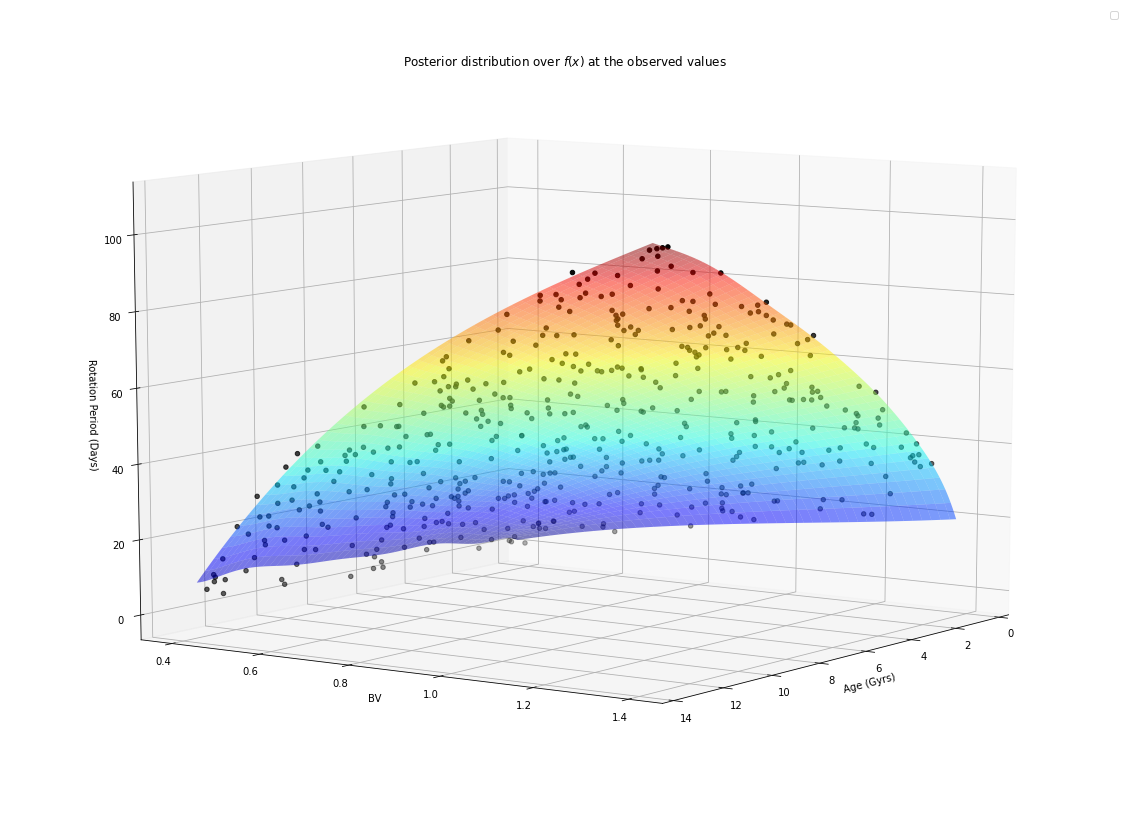

In [9]:

fig = plt.figure(figsize=(20,15))
ax1 = fig.add_subplot(111, projection='3d')



if errorbars:
  for j in range(len(Xnew1)):
    for i in range(len(Xnew1)):
      plt.plot([Xnew1[i,j], Xnew1[i,j]], [Xnew2[i,j], Xnew2[i,j]], [mu[i,j] +sd[i,j], mu[i,j]-sd[i,j]], marker="_" )


ax1.plot_surface(Xnew1, Xnew2, mu, alpha=0.5, cmap=cm.jet, linewidth=0.1)

ax1.set_xlabel("Age (Gyrs)")
ax1.set_ylabel("BV")
ax1.set_zlabel('Rotation Period (Days)')


ax1.scatter(X1, X2, y, color='k')



# axis labels and title

plt.title("Posterior distribution over $f(x)$ at the observed values"); plt.legend()
ax1.view_init(10, 35)
plt.show()





-1.362734484059819


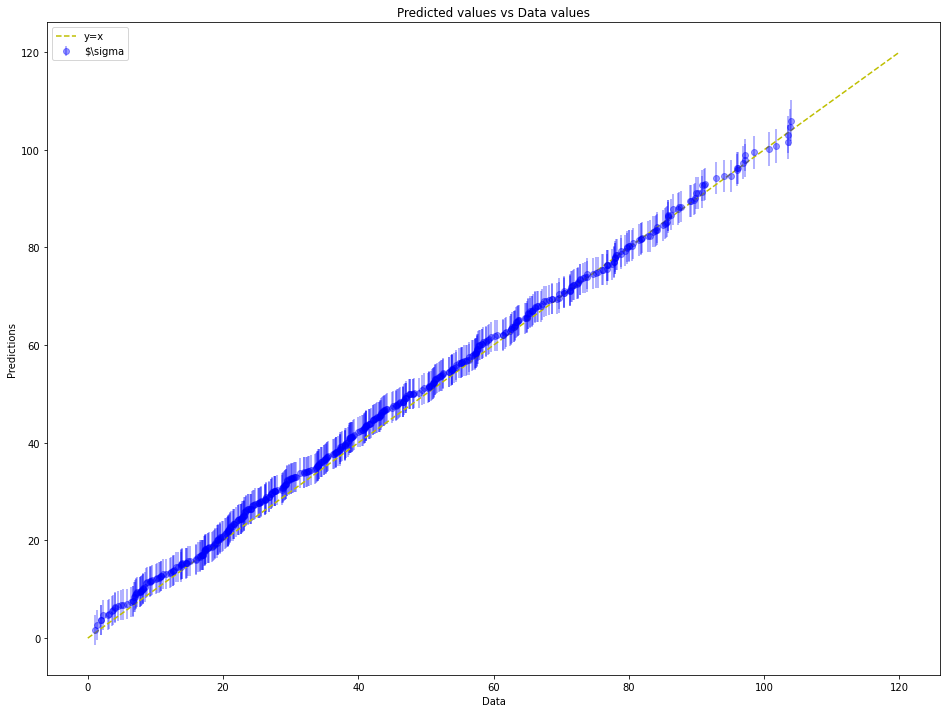

In [10]:
numElems = len(y)
idx = np.round(np.linspace(0, len(mu.reshape(num_gen**2)) - 1, numElems)).astype(int)
# Picks equal spaced elements from (longer) prediction array so that its shape of data

mu_test = (mu.reshape(num_gen**2)[idx])
sd_test = (sd.reshape(num_gen**2)[idx]) 

vals = np.sort([mu_test, sd_test], axis=1)
# sorts them together :) 

fig = plt.figure(figsize=(16,12))

plt.plot([0,120],[0,120], linestyle='--', label='y=x', color='y')
plt.errorbar(np.sort(y), vals[0,:], yerr=vals[1,:], fmt='o', label=r'$\sigma', color='b', alpha=0.4)


plt.xlabel("Data")
plt.ylabel("Predictions")
plt.title("Predicted values vs Data values")
plt.legend()
print(np.mean(np.sort(y)- vals[0,:]))

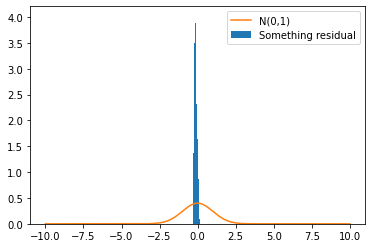

In [11]:
Z = (np.sort(y) - vals[0,:])/vals[1,:]**2

x = np.linspace(-10,10, 1000)
f = 1/np.sqrt(2 * np.pi) * np.exp(-1/2 * x**2)

plt.hist(Z, density=True, label='Something residual')
 
plt.plot(x,f, label='N(0,1)')
plt.legend()
